In [1]:
#lib imports
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#local imports
from utils import *
from plotting import *
from model_creator import *
from mediapipe_utils.mediapipe_transforamtions import *

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Python version: ', os.sys.version)

TensorFlow version:  2.18.0
Keras version:  3.6.0
Python version:  3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]


In [2]:
local_dir = './'
original_data_dir = os.path.join(local_dir, 'unet_utils/postprocessed_segmented_data')
# src_data contains the original data from the Kaggle dataset together with the augmented data from 'resized_images'
dataset_dir = os.path.join(local_dir, 'dataset_unet_classifiers')
models_dir = os.path.join(local_dir, 'models_unet_classifiers')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

src_data = os.path.join(local_dir, 'src_data')
assert os.path.exists(src_data), f'{src_data} not found'

classes = ['rock', 'paper', 'scissors']


if not os.path.exists(original_data_dir):
    raise FileNotFoundError('Original data directory not found')

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    split_dataset(classes, original_data_dir, dataset_dir)

for path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f'{path} not found')
    
    print(path)
    for class_name in classes:
        print(f'    - {class_name}: {len(os.listdir(os.path.join(path, class_name)))} images')

./dataset_unet_classifiers\train
    - rock: 1908 images
    - paper: 1919 images
    - scissors: 1936 images
./dataset_unet_classifiers\val
    - rock: 239 images
    - paper: 240 images
    - scissors: 242 images
./dataset_unet_classifiers\test
    - rock: 239 images
    - paper: 240 images
    - scissors: 243 images


In [3]:
from utils import check_for_duplicates_in_dataset
check_for_duplicates_in_dataset('./dataset_unet_classifiers')

No duplicates found in dataset
7206 files found in dataset


Found 5763 images belonging to 3 classes.
Found 721 images belonging to 3 classes.
Found 722 images belonging to 3 classes.


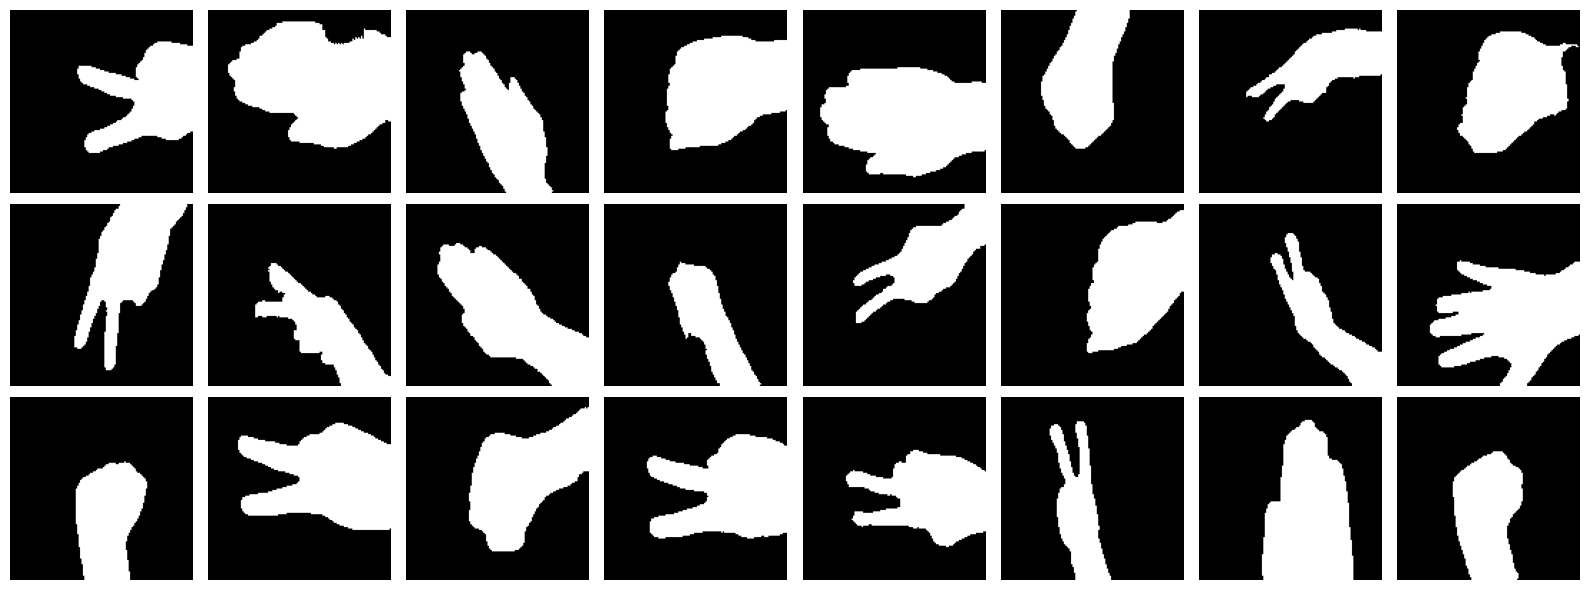

In [8]:
# Image target size
img_rows, img_cols = 128, 128
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    shear_range=0.1,  
    zoom_range=[0.8, 1.2], 
    horizontal_flip=True,  
    fill_mode='constant'  
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=[0.9, 1.1],
    fill_mode='constant'
    )
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    )

#plot_grid_from_generator(train_generator, 5, 5, cmap='gray')
#plot_grid_from_generator(val_generator, 2, 5, cmap='gray')
plot_grid_from_generator(test_generator, 3, 8, cmap='gray')

In [5]:
EPOCHS = 100
MODEL_NAME = 'cnn_unet_classifier_100_epochs'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

csvlogger_callback = tf.keras.callbacks.CSVLogger(
    filename=os.path.join(models_dir, f'{MODEL_NAME}_ckp_history.csv'),     
    separator=',',                      
    append=True                           
)

# Channels: 1 for grayscale (3 for RGB), arg 'input_shape' in the model
hist_dict = compile_and_train_model(
    create_model_func=build_cnn_unet_classifier,
    create_model_args={'input_shape' : (128, 128, 1), 'num_classes' :3},
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'], 
    train_generator=train_generator,
    val_generator=val_generator,
    epochs=EPOCHS,
    models_dir=models_dir,
    model_name=MODEL_NAME,
    callbacks=[checkpoint_callback, csvlogger_callback]
)

c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
  2/181 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - acc: 0.3984 - loss: 2.1145

KeyboardInterrupt: 

In [ ]:
model = tf.keras.models.load_model(os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'))
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

23/23 - 1s - 39ms/step - acc: 0.9432 - loss: 0.1811


<Figure size 640x480 with 0 Axes>

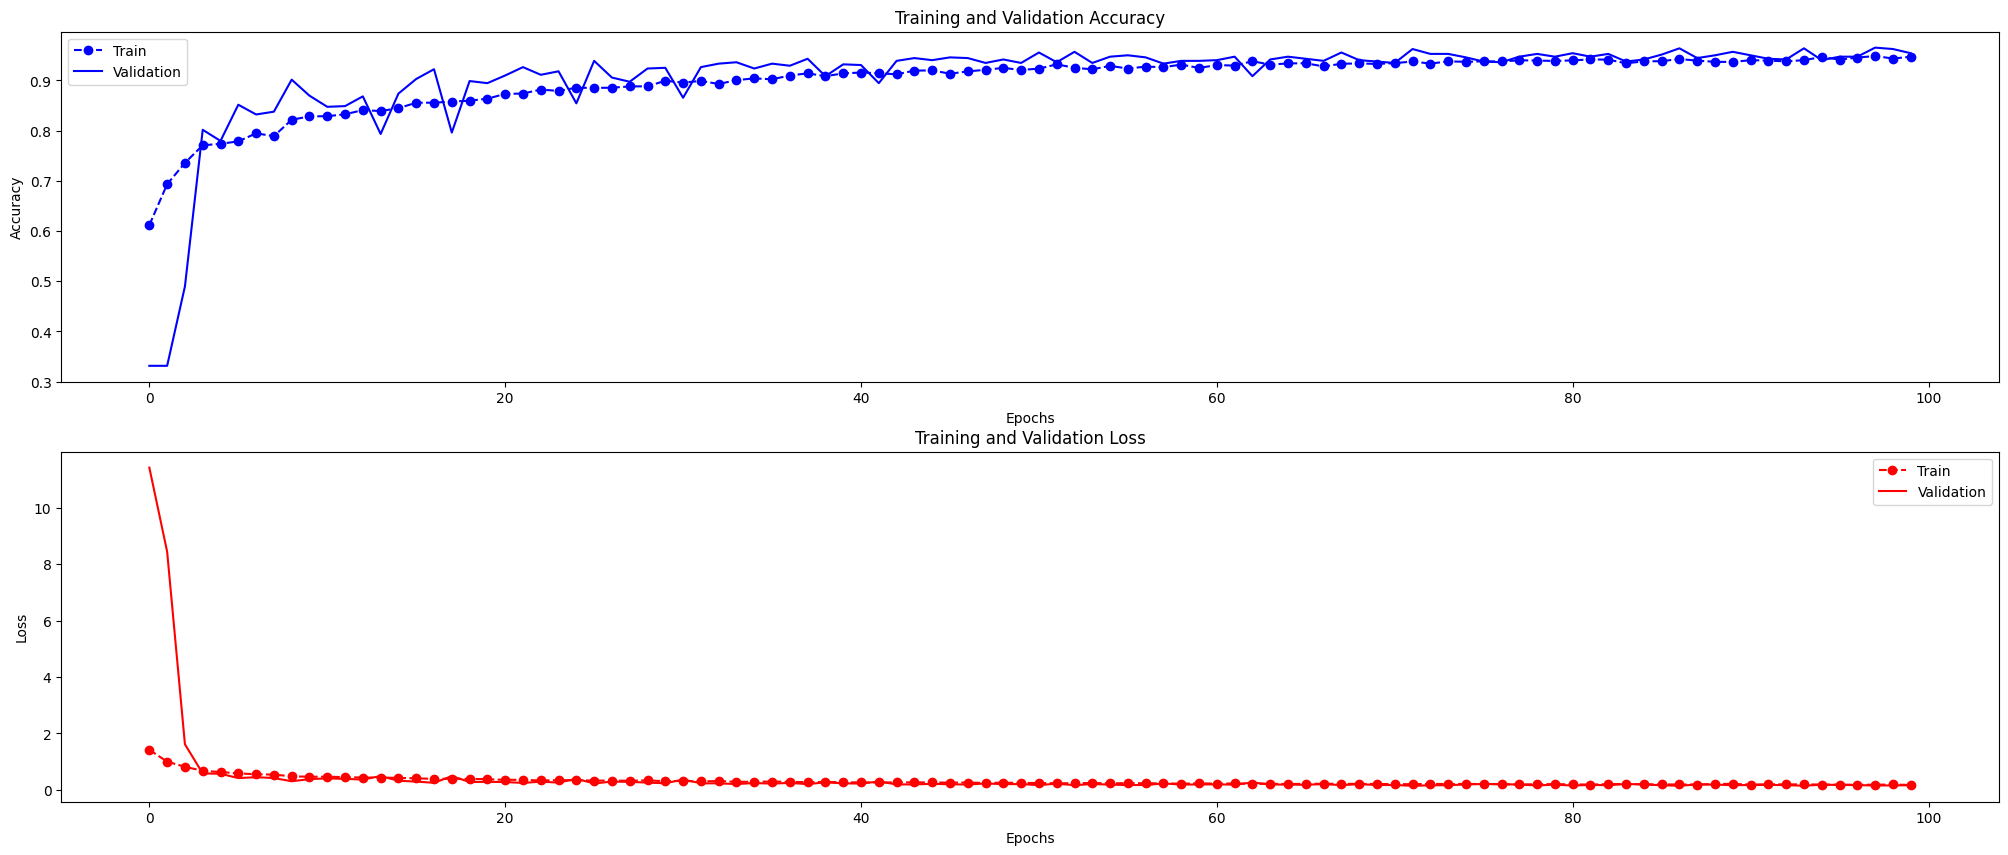

In [ ]:
plot_history_csv(os.path.join(models_dir, f'{MODEL_NAME}_history.csv'))